In [1]:
import pandas as pd
import math
import random
import numpy as np

from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as pyplt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from kneed import KneeLocator

I want to load each of the CSV files in the data directory and then concatenate them into a single DataFrame.

In [2]:
import os

master_df = pd.DataFrame()
data_files = []

for filename in os.listdir("products_dataset"): # Iterates over files in the directory
    if filename.endswith(".csv"): # Check if the file ends with .csv
        data_files.append(filename) # Add the filename to the list
    else:
        continue

print(f"Found the following {len(data_files)} data files: {data_files}" )

Found the following 115 data files: ['Air Conditioners.csv', 'All Appliances.csv', 'All Car and Motorbike Products.csv', 'All Electronics.csv', 'All Exercise and Fitness.csv', 'All Grocery and Gourmet Foods.csv', 'All Home and Kitchen.csv', 'All Pet Supplies.csv', 'All Sports Fitness and Outdoors.csv', 'Amazon Fashion.csv', 'Amazon-Products.csv', 'Baby Bath Skin and Grooming.csv', 'Baby Fashion.csv', 'Baby Products.csv', 'Backpacks.csv', 'Badminton.csv', 'Bags and Luggage.csv', 'Ballerinas.csv', 'Beauty and Grooming.csv', 'Bedroom Linen.csv', 'Camera Accessories.csv', 'Cameras.csv', 'Camping and Hiking.csv', 'Car Accessories.csv', 'Car and Bike Care.csv', 'Car Electronics.csv', 'Car Parts.csv', 'Cardio Equipment.csv', 'Casual Shoes.csv', 'Clothing.csv', 'Coffee Tea and Beverages.csv', 'Cricket.csv', 'Cycling.csv', 'Diapers.csv', 'Diet and Nutrition.csv', 'Dog supplies.csv', 'Ethnic Wear.csv', 'Fashion and Silver Jewellery.csv', 'Fashion Sales and Deals.csv', 'Fashion Sandals.csv', 'Fit

Load the dataset

In [3]:
for i in data_files:
    file_path = os.path.join("products_dataset", i) # Construct the full file path for each file
    df = pd.read_csv(file_path) # Read the CSV file from the path into a DataFrame
    master_df = pd.concat([master_df, df], ignore_index=True) # Concatenate the DataFrame to the master DataFrame

master_df.head()

,name,main_category,sub_category,image,link,ratings,no_of_ratings,discount_price,actual_price,Unnamed: 0
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/31UISB90sY...,https://www.amazon.in/Lloyd-Inverter-Convertib...,4.2,"2,255","₹32,999","₹58,990",NaN
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.2,"2,948","₹46,490","₹75,990",NaN
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Inverter-Convertible-...,4.2,"1,206","₹34,490","₹61,990",NaN
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/51JFb7FctD...,https://www.amazon.in/LG-Convertible-Anti-Viru...,4.0,69,"₹37,990","₹68,990",NaN
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,https://m.media-amazon.com/images/I/41lrtqXPiW...,https://www.amazon.in/Carrier-Inverter-Split-C...,4.1,630,"₹34,490","₹67,790",NaN


For the purposes of the task, I will be removing columns which provide no value to the analysis.
I am keeping the category and sub-category columns as one of the use cases can be to find similar products within a certain category: eg a user views a laptop → recommend other laptops in the same cluster with similar price/specs.

In [4]:
master_df = master_df.drop(columns=['image', 'link', 'Unnamed: 0']) # Drop specified columns

master_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,"2,255","₹32,999","₹58,990"
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.2,"2,948","₹46,490","₹75,990"
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,4.2,"1,206","₹34,490","₹61,990"
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.0,69,"₹37,990","₹68,990"
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,4.1,630,"₹34,490","₹67,790"


We want to ensure all data is empirical
- We will convert the price column to flat by removing the yen symbol using regex matching
- We will convert no_of_ratings to string, remove commas, then convert to float

In [5]:
master_df['discount_price'] = master_df['discount_price'].replace('[\₹,]', '', regex=True).astype(float) # Convert discount_price to float
master_df['actual_price'] = master_df['actual_price'].replace('[\₹,]', '', regex=True).astype(float) # Convert actual_price to float

master_df['ratings'] = pd.to_numeric(master_df['ratings'], errors='coerce') # Convert ratings to float
master_df = master_df.dropna(subset=['ratings']) # Drop NaN values in ratings

master_df['no_of_ratings'] = master_df['no_of_ratings'].astype(str) # Convert object field to str
master_df['no_of_ratings'] = master_df['no_of_ratings'].replace(",", "", regex=True) # Remove commas
master_df['no_of_ratings'] = pd.to_numeric(master_df['no_of_ratings']) # Convert to numeric
master_df = master_df[master_df['actual_price'] <= 2000000] # Drop rows with price over 2 million as these are definite outliers


master_df = master_df.dropna() # Drop rows with missing values

master_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.2,2948.0,46490.0,75990.0
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,4.2,1206.0,34490.0,61990.0
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.0,69.0,37990.0,68990.0
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,4.1,630.0,34490.0,67790.0


Some derived fields can be useful for analysis.
We will calculate the discount amount, the discount percentage, the price-rating ratio

In [6]:
master_df['discount'] = master_df['actual_price'] - master_df['discount_price'] # Calculate discount
master_df['discount_percentage'] = ((master_df['discount'] / master_df['actual_price']) * 100).round(2) # Calculate discount percentage
master_df['price_rating_ratio'] = (master_df['actual_price'] / master_df['ratings']).round(3) # Calculate price-rating ratio

master_df.head()

,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,25991.0,44.06,14045.238
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.2,2948.0,46490.0,75990.0,29500.0,38.82,18092.857
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,4.2,1206.0,34490.0,61990.0,27500.0,44.36,14759.524
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.0,69.0,37990.0,68990.0,31000.0,44.93,17247.500
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,4.1,630.0,34490.0,67790.0,33300.0,49.12,16534.146


The features operate on different scales, so I need to standardise the data
- I will use Min-Max scaling to standardise the data

In [7]:
def min_max_scaling(df, column):
    min = df[column].min() # Getting the min value in the col
    max = df[column]. max() # Getting the max value in the col

    def func(x):
        return (((x-min)/(max-min))) # Calculating min-max formula

    df[column] = df[column].apply(func) # Applying formula to all values in the column

In [8]:
def get_num_cols(df):
    return df.select_dtypes(include='number').columns.tolist()

In [9]:
def generate_filtered_df(current_product):
    filtered_df = master_df # Save my dataframe

    # Filter the dataframe to only show records where the sub-category matches their
    # current product selection
    filt = current_product['sub_category'].iloc[0]
    print(filt)
    filtered_df = filtered_df[filtered_df['sub_category'] == filt] 

    # Display only the numeric columns (avoids having to drop columns when we need them later)
    filtered_df = filtered_df.filter(items=get_num_cols(filtered_df))

    filtered_df.head()

    return filtered_df

Building my K-Means++ Algorithm with a class based approach

In [10]:
Point = namedtuple('Point', ['x', 'y']) # Making each data point a tuple

class Cluster: # Creating the Cluster class
    def __init__(self, label, center: Point): # Initialising values
        self.label = label
        self.center = (center.x, center.y)
        self.wcss = 0.0
        self.points_index = []

    def get_label(self):
        return self.label
    
    def get_center(self):
        return self.center
    
    def get_wcss(self):
        return self.wcss
    
    def get_points(self):
        return self.points_index

    def set_center(self, new_center):
        self.center = new_center

    def add_point(self, point):
        self.points_index.append(point)
        dx = point.x - self.center[0]
        dy = point.y - self.center[1]
        # accumulate squared distance
        self.wcss += dx*dx + dy*dy
    
    def reset_points(self):
        self.points_index = []
        self.wcss = 0.0

    def update_wcss(self, update_val):
        self.wcss = update_val

In [ ]:
def k_means(dataset, clusters):
    #Assign random points as cluster centers to begin
    #Calculate distance from each center and assign to closest center
    def assign_point_to_cluster(point):
        closest_cluster = None # Initialize closest cluster
        current_closest_distance = float('inf') # Initialize current closest distance to infinity
        for cluster in clusters: # Iterate through each cluster
            point_cluster_distance = math.sqrt((point.y - cluster.get_center()[1])**2 + (point.x - cluster.get_center()[0])**2) # Calculate distance from point to cluster center
            if point_cluster_distance < current_closest_distance: # If the distance is less than the current closest distance
                closest_cluster = cluster # Update closest cluster
                current_closest_distance = point_cluster_distance # Update current closest distance
        closest_cluster.add_point(point) # Add the point to the closest cluster
    
    def recalculate_cluster_center(cluster):
        tolerance = 3 # Tolerance for center change
        total_x = 0 # Initialize total x-coordinate sum
        total_y = 0 # Initialize total y-coordinate sum

        if len(cluster.get_points()) == 0: # Skip updating this cluster if it has no points
            return False

        for point in cluster.get_points():
            total_x += point.x # Sum up x-coordinates of points in the cluster
            total_y += point.y # Sum up y-coordinates of points in the cluster
        new_center = (total_x/len(cluster.get_points()), total_y/len(cluster.get_points())) # Calculate new center of the cluster by finding the average of all points in the cluster
        if (new_center != cluster.get_center()) or ((new_center[0] > cluster.get_center()[0] + tolerance) and (new_center[1] > cluster.get_center()[1] + tolerance)): # Check if the new center is different from the current center
            cluster.set_center(new_center) # Update the cluster center
            return True
        else:
            return False

    all_centers_unchanged = False # Flag to check if all cluster centers have remained unchanged
    cluster_change_list = [] # Initialize list to track changes in cluster centers

    while not all_centers_unchanged: # While loop to keep iterating until all centers are unchanged
        cluster_change_list = [] # Reset the change list for this iteration
        for point in dataset: # Iterate through each point in the dataset
            assign_point_to_cluster(point) # Assign each point to the closest cluster

        for cluster in clusters: # Iterate through each cluster
            cluster_change_list.append(recalculate_cluster_center(cluster)) # Recalculate the center of each cluster
            cluster.reset_points() # Reset the points in the cluster for the next iteration

        if True in cluster_change_list: # If any cluster center has changed
            cluster_change_list = [] # Reset the change list for the next iteration
        else:
            all_centers_unchanged = True # Set the flag to True to exit the loop

    cluster_labels = [] # Initialize list to store cluster labels

    for point in dataset: # Iterate through each point in the dataset
        closest_cluster = None # Initialize closest cluster
        min_dist = float('inf') # Initialize minimum distance to infinity
        for cluster in clusters: # Iterate through each cluster to find the closest one
            dx = point.x - cluster.get_center()[0] # Calculate the difference in x-coordinates
            dy = point.y - cluster.get_center()[1] # Calculate the difference in y-coordinates
            dist = dx**2 + dy**2 # Calculate the squared distance from the point to the cluster center
            if dist < min_dist: # If the distance is less than the current minimum distance
                min_dist = dist # Update the minimum distance
                closest_cluster = cluster # Update the closest cluster
        closest_cluster.add_point(point) # Add the point to the closest cluster
        cluster_labels.append(closest_cluster.get_label()) # Append the label of the closest cluster to the list

    return clusters, cluster_labels

Method to find what K should be

In [25]:
# Elbow Method

def get_total_wcss(dataset, clusters_list):
    total_wcss = 0 # Accumalator for the WCSS
    clusters, c_list = k_means(dataset, clusters_list) # Running K-Means algo
    for cluster in clusters:
        total_wcss += cluster.get_wcss() # Summing the WCSS of that cluster with the running total
    
    return total_wcss

def elbow_method(sample_set, pca):
    reduced_data = pca.fit_transform(sample_set) # Reducing dataset to 2-D so k-means can be run later
    # random.seed(2) # Saving the seed to allow easier testing

    running_total = [] # Keeping track of WCSS for each set of clusters
    for k in range(1, 15): # Want to test 15 centers
        centers_k = random.sample(list(reduced_data), k) # Taking a random sample of k datapoints to be centers
        clusters_k = [Cluster(label=i, center=Point(x=centers_k[i][0], y=centers_k[i][1])) for i in range(k)] # Creating k clusters

        wcss_k = get_total_wcss([Point(x, y) for x, y in reduced_data], clusters_k) # Getting the total WCSS for that k-clusters sets
        running_total.append(wcss_k) # Appending the WCSS for that k-clusters set to the array

    return running_total

def optimal_k(running_total):
    knee = KneeLocator([i for i in range(1, 15)], running_total, curve='convex', direction='decreasing') # Creating the 'knee'
    optimal_k = knee.knee # Finding the turning point
    
    print(optimal_k)

    return optimal_k

def print_elbow(running_total):
    pyplt.plot(range(1, 15), running_total, marker='o')
    pyplt.title('Elbow Method For Optimal k')
    pyplt.xlabel('Number of clusters (k)')
    pyplt.ylabel('Total WCSS')
    pyplt.grid(True)
    pyplt.show()

In [26]:
# Test Product: "Lloyd 1.5 Ton 5 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White With Chr..."
# Test Product: "Bajaj DX-6 1000W Dry Iron with Advance Soleplate and Anti-bacterial German Coating Technology, White"

this_product = str(input("Enter the full name of the product: "))

# Use this product to test
# In a real system, when they select a product, the dataframe record of that product will be returned automatically
#chosen_product = master_df.query('name =="Lloyd 1.5 Ton 5 Star Inverter Split Ac (5 In 1 Convertible, Copper, Anti-Viral + Pm 2.5 Filter, 2023 Model, White With Chr..."') 
chosen_product = master_df[master_df['name'] == this_product]
filtered_df = generate_filtered_df(chosen_product)
filtered_df.head()

Air Conditioners


,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,4.2,2255.0,32999.0,58990.0,25991.0,44.06,14045.238
1,4.2,2948.0,46490.0,75990.0,29500.0,38.82,18092.857
2,4.2,1206.0,34490.0,61990.0,27500.0,44.36,14759.524
3,4.0,69.0,37990.0,68990.0,31000.0,44.93,17247.500
4,4.1,630.0,34490.0,67790.0,33300.0,49.12,16534.146


In [27]:
scaled_df = filtered_df

for column in scaled_df.columns[0:]: # Iterate over each column
    min_max_scaling(scaled_df, column) # Apply min-max to each column

scaled_df.head()

,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,0.800,0.444401,0.255052,0.393876,0.595217,0.725845,0.178984
1,0.800,0.581033,0.359958,0.508353,0.676294,0.636395,0.231026
2,0.800,0.237579,0.266646,0.414078,0.630083,0.730966,0.188167
3,0.750,0.013407,0.293862,0.461216,0.710952,0.740696,0.220157
4,0.775,0.124014,0.266646,0.453135,0.764094,0.812223,0.210985


4


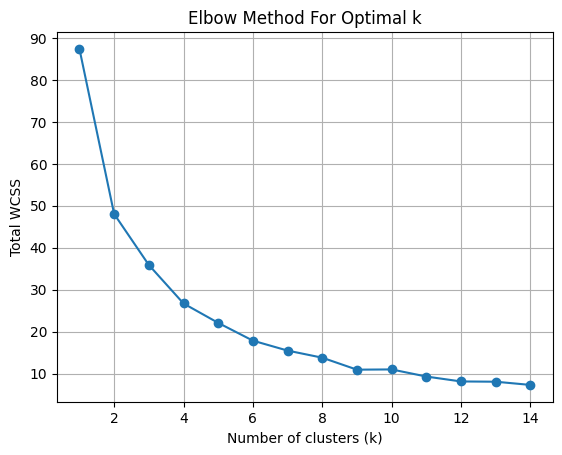

In [28]:
pca = PCA(n_components=2)

elbow = elbow_method(scaled_df, pca) # Record the WCSS's accumalated
optimal_k = optimal_k(elbow) # Automatically calculate the optimal k and store it
print_elbow(elbow) # Show the elbow graph

In [29]:
reduced_df = pca.fit_transform(scaled_df) # Reduced the dataset using PCA
dataset = [Point(x, y) for x, y in reduced_df] # Storing all the (x,y) pairs in an array

# Pick 4 distinct points as initial centers
initial_centers = random.sample(list(reduced_df), optimal_k+1) # Randomly choosing optimal_k initial centers

# Build clusters
clusters = [
    Cluster(label=i, center=Point(x=center[0], y=center[1])) # Labelling cluster wth i and assigning its center to the x and y points of the initial centers
    for i, center in enumerate(initial_centers)
]

for k in range(1, optimal_k+1):
    centers_k = random.sample(list(reduced_df), k)
    clusters_k = [Cluster(label=i, center=Point(x=centers_k[i][0], y=centers_k[i][1])) for i in range(k)]

clusters_custom, cluster_labels_custom = k_means(dataset, clusters_k)

In [30]:
# Comparing to scikitlearn implementation

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_sklearn = kmeans.fit_predict(reduced_df)

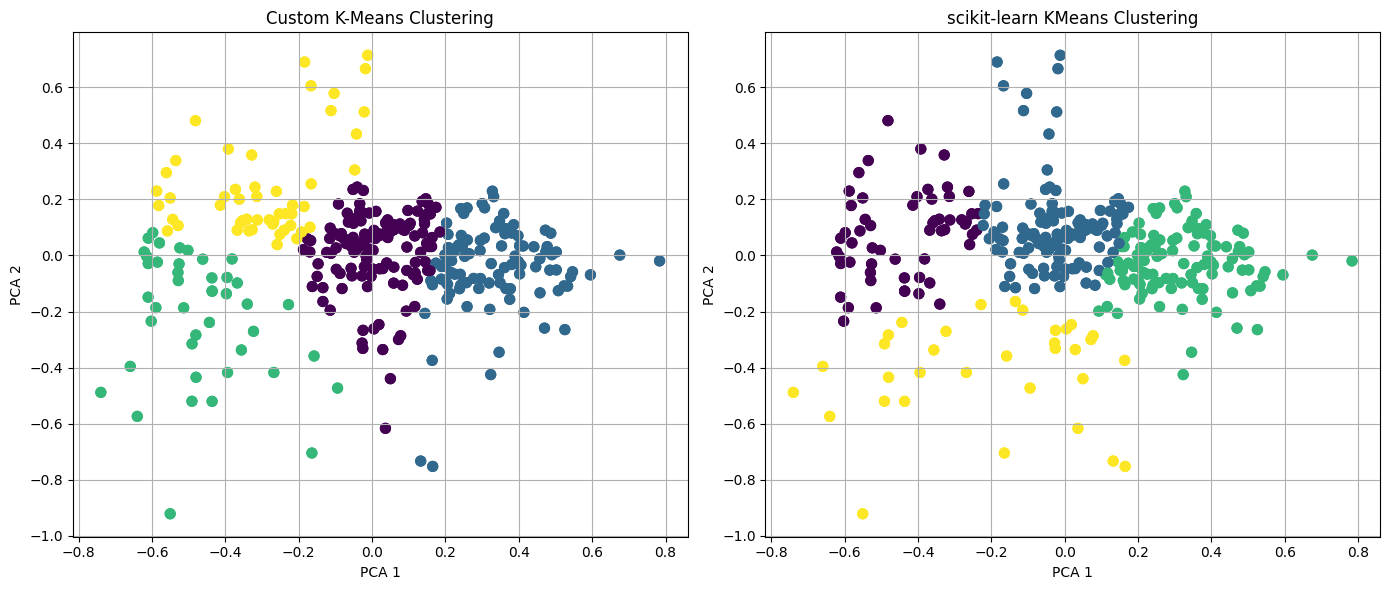

In [31]:

x = [point[0] for point in reduced_df]
y = [point[1] for point in reduced_df]

fig, axs = pyplt.subplots(1, 2, figsize=(14, 6))

# Plot custom K-Means
axs[0].scatter(x, y, c=cluster_labels_custom, cmap='viridis', s=50)
axs[0].set_title('Custom K-Means Clustering')
axs[0].set_xlabel('PCA 1')
axs[0].set_ylabel('PCA 2')
axs[0].grid(True)

# Plot scikit-learn KMeans
axs[1].scatter(x, y, c=cluster_labels_sklearn, cmap='viridis', s=50)
axs[1].set_title('scikit-learn KMeans Clustering')
axs[1].set_xlabel('PCA 1')
axs[1].set_ylabel('PCA 2')
axs[1].grid(True)

pyplt.tight_layout()
pyplt.show()

In [32]:
silhouette_custom = silhouette_score(reduced_df, cluster_labels_custom)
print(f"Silhouette Score (Custom K-Means): {silhouette_custom:.3f}")

silhouette_sklearn = silhouette_score(reduced_df, cluster_labels_sklearn)
print(f"Silhouette Score (scikit-learn KMeans): {silhouette_sklearn:.3f}")

Silhouette Score (Custom K-Means): 0.368
Silhouette Score (scikit-learn KMeans): 0.396


In [33]:
# Displaying the clusters with their centers
for cluster in clusters_custom:
    print(f"Cluster {cluster.get_label()}: Center = {cluster.get_center()}, WCSS = {cluster.get_wcss()}, Points = {len(cluster.get_points())}")

Cluster 0: Center = (np.float64(0.011986177470823069), np.float64(0.013486743218138052)), WCSS = 7.137720208144209, Points = 252
Cluster 1: Center = (np.float64(0.33371680600714976), np.float64(-0.04341267752214142)), WCSS = 7.860703699073969, Points = 202
Cluster 2: Center = (np.float64(-0.46965906682670316), np.float64(-0.21960327655929754)), WCSS = 6.041399221887787, Points = 86
Cluster 3: Center = (np.float64(-0.29451599793132643), np.float64(0.23780964071177785)), WCSS = 5.6683461197023375, Points = 102


,name,main_category,sub_category,ratings,no_of_ratings,discount_price,actual_price,discount,discount_percentage,price_rating_ratio
0,Lloyd 1.5 Ton 3 Star Inverter Split Ac (5 In 1...,appliances,Air Conditioners,4.2,2255.0,32999.0,58990.0,25991.0,44.06,14045.238
1,LG 1.5 Ton 5 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.2,2948.0,46490.0,75990.0,29500.0,38.82,18092.857
2,LG 1 Ton 4 Star Ai Dual Inverter Split Ac (Cop...,appliances,Air Conditioners,4.2,1206.0,34490.0,61990.0,27500.0,44.36,14759.524
3,LG 1.5 Ton 3 Star AI DUAL Inverter Split AC (C...,appliances,Air Conditioners,4.0,69.0,37990.0,68990.0,31000.0,44.93,17247.500
4,Carrier 1.5 Ton 3 Star Inverter Split AC (Copp...,appliances,Air Conditioners,4.1,630.0,34490.0,67790.0,33300.0,49.12,16534.146
...,...,...,...,...,...,...,...,...,...,...
29341,Electrolux 1.8 Ton 3 Star Inverter Split Air C...,appliances,Air Conditioners,5.0,1.0,50990.0,83990.0,33000.0,39.29,16798.000
29350,Hyundai 1.5 Ton Inverter 3 Star Copper (2022 R...,appliances,Air Conditioners,5.0,1.0,30500.0,54990.0,24490.0,44.54,10998.000
29396,Voltas 1.5 Ton 3 Star Split Inverter Air Condi...,appliances,Air Conditioners,5.0,1.0,36490.0,59990.0,23500.0,39.17,11998.000
29436,Haier 1.5 Ton 3 Star Inverter Split Air Condit...,appliances,Air Conditioners,1.0,2.0,42300.0,69500.0,27200.0,39.14,69500.000


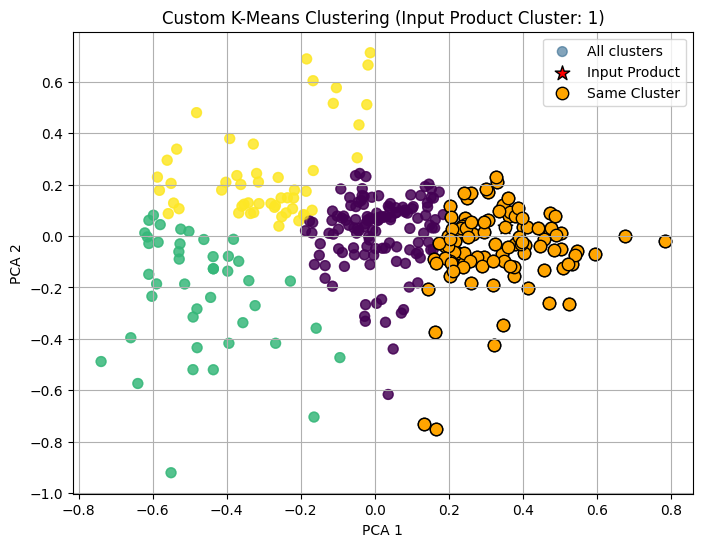

In [34]:
# Find the cluster label for the input product
input_index = chosen_product.index[0]
input_cluster_label = cluster_labels_custom[filtered_df.index.get_loc(input_index)]

# Get indices of all datapoints in the same cluster (excluding the input product)
same_cluster_indices = [
    idx for idx, label in zip(filtered_df.index, cluster_labels_custom)
    if label == input_cluster_label and idx != input_index
]

# Display the other datapoints in the same cluster
other_products_same_cluster = master_df.loc[same_cluster_indices]
display(other_products_same_cluster)

# Visualize and highlight the cluster of the input product
import matplotlib.pyplot as plt

x = [point[0] for point in reduced_df]
y = [point[1] for point in reduced_df]

plt.figure(figsize=(8, 6))
# Plot all points, colored by cluster
plt.scatter(x, y, c=cluster_labels_custom, cmap='viridis', s=50, alpha=0.6, label='All clusters')
# Highlight the input product
plt.scatter(
    reduced_df[filtered_df.index.get_loc(input_index), 0],
    reduced_df[filtered_df.index.get_loc(input_index), 1],
    color='red', s=120, edgecolor='black', marker='*', label='Input Product'
)
# Highlight other products in the same cluster
same_cluster_locs = [filtered_df.index.get_loc(idx) for idx in same_cluster_indices]
plt.scatter(
    [reduced_df[i, 0] for i in same_cluster_locs],
    [reduced_df[i, 1] for i in same_cluster_locs],
    color='orange', s=80, edgecolor='black', marker='o', label='Same Cluster'
)
plt.title(f'Custom K-Means Clustering (Input Product Cluster: {input_cluster_label})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()